In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

<h1>Lab 2: Metadynamics

In [2]:
def MoroCardin(x):
    #This is the morocardin potential 
    alpha = np.arctan(7*math.pi/9)
    
    V = 5*(x[:,0]**2-1)**2 + 10*alpha*x[:,1]**2
    
    return V

In [3]:
def MoroCardin_grad(x, y):
    #this is the gradient of the morocardin potential 
    alpha = np.arctan(7*math.pi/9)

    dVdx = 10*(x**2-1)*2*x
    dVdy = 20*alpha*y
    return dVdx, dVdy
    


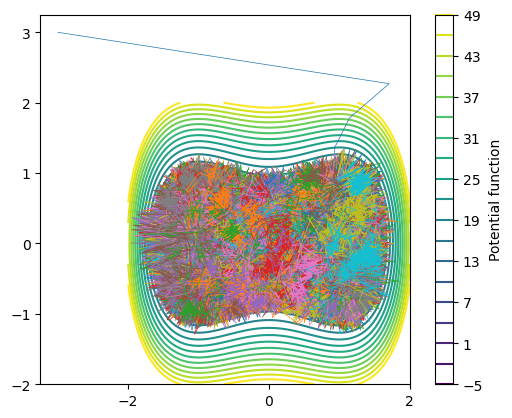

In [4]:
# Generate a dataset using metadynamics
# Parameters for metadynamics
Ndeposit = 500
Nbumps = 1000
height = 1
sig = 0.1
sig2 = sig**2
beta = 3.0;
h=0.01 # time step
sqh = math.sqrt(h*2/beta)
traj = np.zeros((Ndeposit,2))
coef = np.zeros((Nbumps,1))
xbump = np.zeros((Nbumps,2))
# initial point
xa = -3
ya = 3
x0 = np.array([xa,ya])
# np.matmul(a1,a2) does matrix multiplication
# np.multiply(a1,a2) does elementwise multiplication
# np.dot(a1,a2) does dot product of two arrays

#plot the contours
x_grid = np.linspace(-2, 2, 100)
y_grid = np.linspace(-2, 2, 100)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
gridpoints = np.c_[x_grid.ravel(), y_grid.ravel()]
v_grid = MoroCardin(gridpoints)
v_grid = np.reshape(v_grid, x_grid.shape)
ls = plt.contour(x_grid,y_grid,v_grid,range(-5,50, 3))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})

#perform and plot the metadynamics
net_traj = np.zeros((Ndeposit*Nbumps, 2))
for k in range(Nbumps):
    traj[0,:] = x0
    w = sqh*np.random.normal(0,1,(Ndeposit-1,2))
    for j in range(Ndeposit-1):
        dVface = np.array(MoroCardin_grad(traj[j][0],traj[j][1]));
        aux1 = np.reshape(traj[j][0]-xbump[:,0],(Nbumps,1))
        aux2 = np.reshape(traj[j][1]-xbump[:,1],(Nbumps,1))
        c1 = np.outer(coef,np.array([1,1]))
        c1aux = np.multiply(c1,np.hstack((aux1,aux2)))
        c1auxexp = np.multiply(c1aux,np.outer(np.exp(-(0.5/sig2)*np.array(aux1**2+aux2**2)),np.array([1,1])))
        dVbump = np.sum(c1auxexp,axis=0)/sig2;
        traj[j+1,:] = traj[j,:] - h*(dVface-dVbump) + w[j,:];
    plt.plot(traj[:,0],traj[:,1], linewidth=.5)
    net_traj[500*k:500*(k+1)]=traj
    # deposit bump
    x0 = traj[j+1,:]
    xbump[k,:] = x0
    coef[k] = height;
plt.show()

<h3>Delta-Net Algorithm</h3>
<p>Used to create a set of points to explore more of the potential space

In [5]:
def delta_net(traj, delta):
    #main algorithm
    Z = traj
    Zboolindex = np.zeros(shape=Z.shape[0], dtype='bool')
    Zboolindex[0] = True
    
    for i in range(1, len(Z)):
        point = Z[i]
        dists = np.sqrt(np.sum((Z[Zboolindex]-np.reshape(point, (1, -1)))**2, axis=1))
        if dists.min() > delta:
            Zboolindex[i] = True
            
    
    Z = Z[Zboolindex]
    Zboolindex = np.full(len(Z), 1, dtype='bool')
    
    for i in range(0, len(Z)):
        Zboolindex[i] = False
        point = Z[i]
        
        dists = np.sqrt(np.sum((Z[Zboolindex]-np.reshape(point, (1, -1)))**2, axis=1))
        Zboolindex[i] = True
        if dists.min() > 2*delta:
            Zboolindex[i] = False
    
    Z = Z[Zboolindex]

    return Z

In [6]:
mynet = delta_net(net_traj[::20], .03)

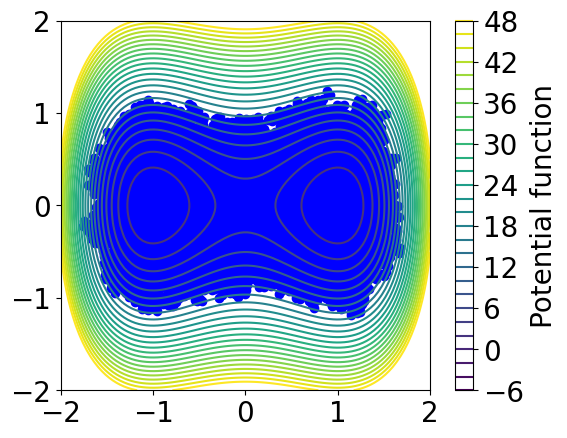

In [7]:
x_grid = np.linspace(-2, 2, 100)
y_grid = np.linspace(-2, 2, 100)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
gridpoints = np.c_[x_grid.ravel(), y_grid.ravel()]
v_grid = MoroCardin(gridpoints)
v_grid = np.reshape(v_grid, x_grid.shape)
ls = plt.contour(x_grid,y_grid,v_grid,range(-6,50, 2))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
plt.scatter(mynet[:,0], mynet[:,1], c='b')
plt.show()

<h3>New potential</h3>

In [8]:
def face(x,y):
    xa=-3
    ya=3
    xb=0 
    yb=4.5
    f=(1-x)**2+(y-0.25*x**2)**2+1
    g1=1-np.exp(-0.125*((x-xa)**2+(y-ya)**2))
    g2=1-np.exp(-0.25*(((x-xb)**2+(y-yb)**2)))
    g3=1.2-np.exp(-2*((x+0)**2+(y-2)**2))
    g4=1+np.exp(-2*(x+1.5)**2-(y-3.5)**2-(x+1)*(y-3.5))
    v = f*g1*g2*g3*g4
    return v


def face_grad(x,y):
    xa=-3
    ya=3
    xb=0 
    yb=4.5
    f=(1-x)**2+(y-0.25*x**2)**2+1
    g1=1-np.exp(-0.125*((x-xa)**2+(y-ya)**2))
    g2=1-np.exp(-0.25*(((x-xb)**2+(y-yb)**2)))
    g3=1.2-np.exp(-2*((x+0)**2+(y-2)**2))
    g4=1+np.exp(-2*(x+1.5)**2-(y-3.5)**2-(x+1)*(y-3.5))

    fx=2*(x-1)+x*(0.25*x**2-y)
    fy=2*(y-0.25*x**2)
    g1x=0.25*(x-xa)*np.exp(-0.125*((x-xa)**2+(y-ya)**2))
    g1y=0.25*(y-ya)*np.exp(-0.125*((x-xa)**2+(y-ya)**2))
    g2x=0.5*(x-xb)*np.exp(-0.25*(((x-xb)**2+(y-yb)**2)))
    g2y=0.5*(y-yb)*np.exp(-0.25*(((x-xb)**2+(y-yb)**2)))
    g3x=4*x*np.exp(-2*(x**2+(y-2)**2))
    g3y=4*(y-2)*np.exp(-2*(x**2+(y-2)**2))
    g4x=-(4*(x+1.5)+(y-3.5))*np.exp(-2*(x+1.5)**2-(y-3.5)**2-(x+1)*(y-3.5))
    g4y=-(2*(y-3.5)+(x+1))*np.exp(-2*(x+1.5)**2-(y-3.5)**2-(x+1)*(y-3.5))

    vx=(fx*g1*g2*g3*g4+f*g1x*g2*g3*g4+f*g1*g2x*g3*g4+
        f*g1*g2*g3x*g4+f*g1*g2*g3*g4x)
    vy=(fy*g1*g2*g3*g4+f*g1y*g2*g3*g4+f*g1*g2y*g3*g4+
        f*g1*g2*g3y*g4+f*g1*g2*g3*g4y)
    dV = np.array([vx,vy])
    return dV   

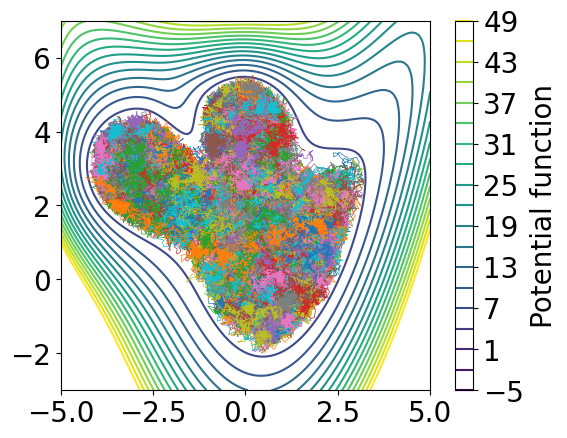

In [9]:
# Generate a dataset using metadynamics
# Parameters for metadynamics
Ndeposit = 500
Nbumps = 1000
height = 1
sig = 0.1
sig2 = sig**2
beta = 3.0;
h=0.01 # time step
sqh = math.sqrt(h*2/beta)
traj = np.zeros((Ndeposit,2))
coef = np.zeros((Nbumps,1))
xbump = np.zeros((Nbumps,2))
# initial point
xa = -3
ya = 3
x0 = np.array([xa,ya])

#plot the contours
x_grid = np.linspace(-5, 5, 100)
y_grid = np.linspace(-3, 7, 100)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
gridpoints = np.c_[x_grid.ravel(), y_grid.ravel()]
v_grid = face(gridpoints[:,0], gridpoints[:,1])
v_grid = np.reshape(v_grid, x_grid.shape)
ls = plt.contour(x_grid,y_grid,v_grid,range(-5,50, 3))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})

net_traj_2 = np.zeros((Ndeposit*Nbumps, 2))
for k in range(Nbumps):
    traj[0,:] = x0
    w = sqh*np.random.normal(0,1,(Ndeposit-1,2))
    for j in range(Ndeposit-1):
        dVface = np.array(face_grad(traj[j][0],traj[j][1]));
        aux1 = np.reshape(traj[j][0]-xbump[:,0],(Nbumps,1))
        aux2 = np.reshape(traj[j][1]-xbump[:,1],(Nbumps,1))
        c1 = np.outer(coef,np.array([1,1]))
        c1aux = np.multiply(c1,np.hstack((aux1,aux2)))
        c1auxexp = np.multiply(c1aux,np.outer(np.exp(-(0.5/sig2)*np.array(aux1**2+aux2**2)),np.array([1,1])))
        dVbump = np.sum(c1auxexp,axis=0)/sig2;
        traj[j+1,:] = traj[j,:] - h*(dVface-dVbump) + w[j,:];
    plt.plot(traj[:,0],traj[:,1], linewidth=.5)
    net_traj_2[500*k:500*(k+1)]=traj
    # deposit bump
    x0 = traj[j+1,:]
    xbump[k,:] = x0
    coef[k] = height;
plt.show()

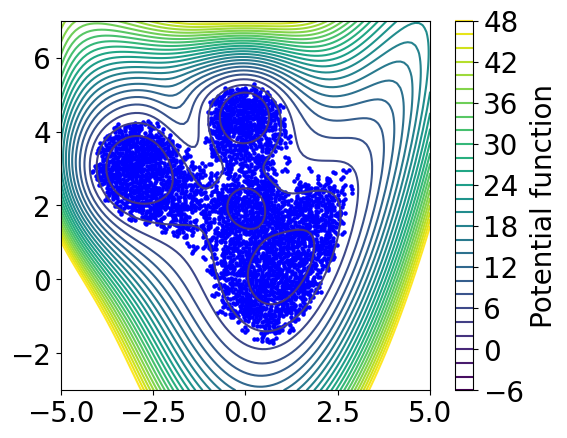

In [10]:
x_grid = np.linspace(-5, 5, 100)
y_grid = np.linspace(-3, 7, 100)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
gridpoints = np.c_[x_grid.ravel(), y_grid.ravel()]
v_grid = face(gridpoints[:,0], gridpoints[:,1])
v_grid = np.reshape(v_grid, x_grid.shape)
ls = plt.contour(x_grid,y_grid,v_grid,range(-6,50, 2))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
mynet2 = delta_net(net_traj_2[::50], .05)
plt.scatter(mynet2[:,0], mynet2[:,1], c='b', s=5)

plt.show()